In [1]:
# PROJECT SETUP

import logging
import os
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import cmdstanpy
from cmdstanpy import CmdStanModel

cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_odds_ratio"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'ds4p')

%config InlineBackend.figure_format = "retina"

In [3]:
stan_file = os.path.join(project_directory, 'stan', 'odds-ratio.stan')
model = CmdStanModel(stan_file=stan_file)

In [4]:
print(model.code())

//  Comparison of two groups with Binomial
data {
  int<lower=0> N1; // number of experiments in group 1
  int<lower=0> y1; // number of events in group 1
  int<lower=0> N2; // number of experiments in group 2
  int<lower=0> y2; // number of events in group 2
}
parameters {
  real<lower=0, upper=1> theta1; // probability of event in group 1
  real<lower=0, upper=1> theta2; // probability of event in group 2
}
model {
  // model block creates the log density to be sampled
  theta1 ~ beta(1, 1); // prior
  theta2 ~ beta(1, 1); // prior
  y1 ~ binomial(N1, theta1); // observation model / likelihood
  y2 ~ binomial(N2, theta2); // observation model / likelihood
}
generated quantities {
  real oddsratio = (theta1 / (1 - theta1)) / (theta2 / (1 - theta2));
}



In [5]:
n1 = 155
y1 = 108
n2 = 57
y2 = 28

stan_data = {
    'N1': n1,
    'y1': y1,
    'N2': n2,
    'y2': y2
}

print(stan_data)

{'N1': 155, 'y1': 108, 'N2': 57, 'y2': 28}


In [6]:
trace = model.sample(
    data=stan_data,
    iter_warmup=1_000,
    iter_sampling=2_000,
    seed=123,
    show_progress=False,
    show_console=False
)

In [7]:
or_draws = trace.stan_variable('oddsratio')

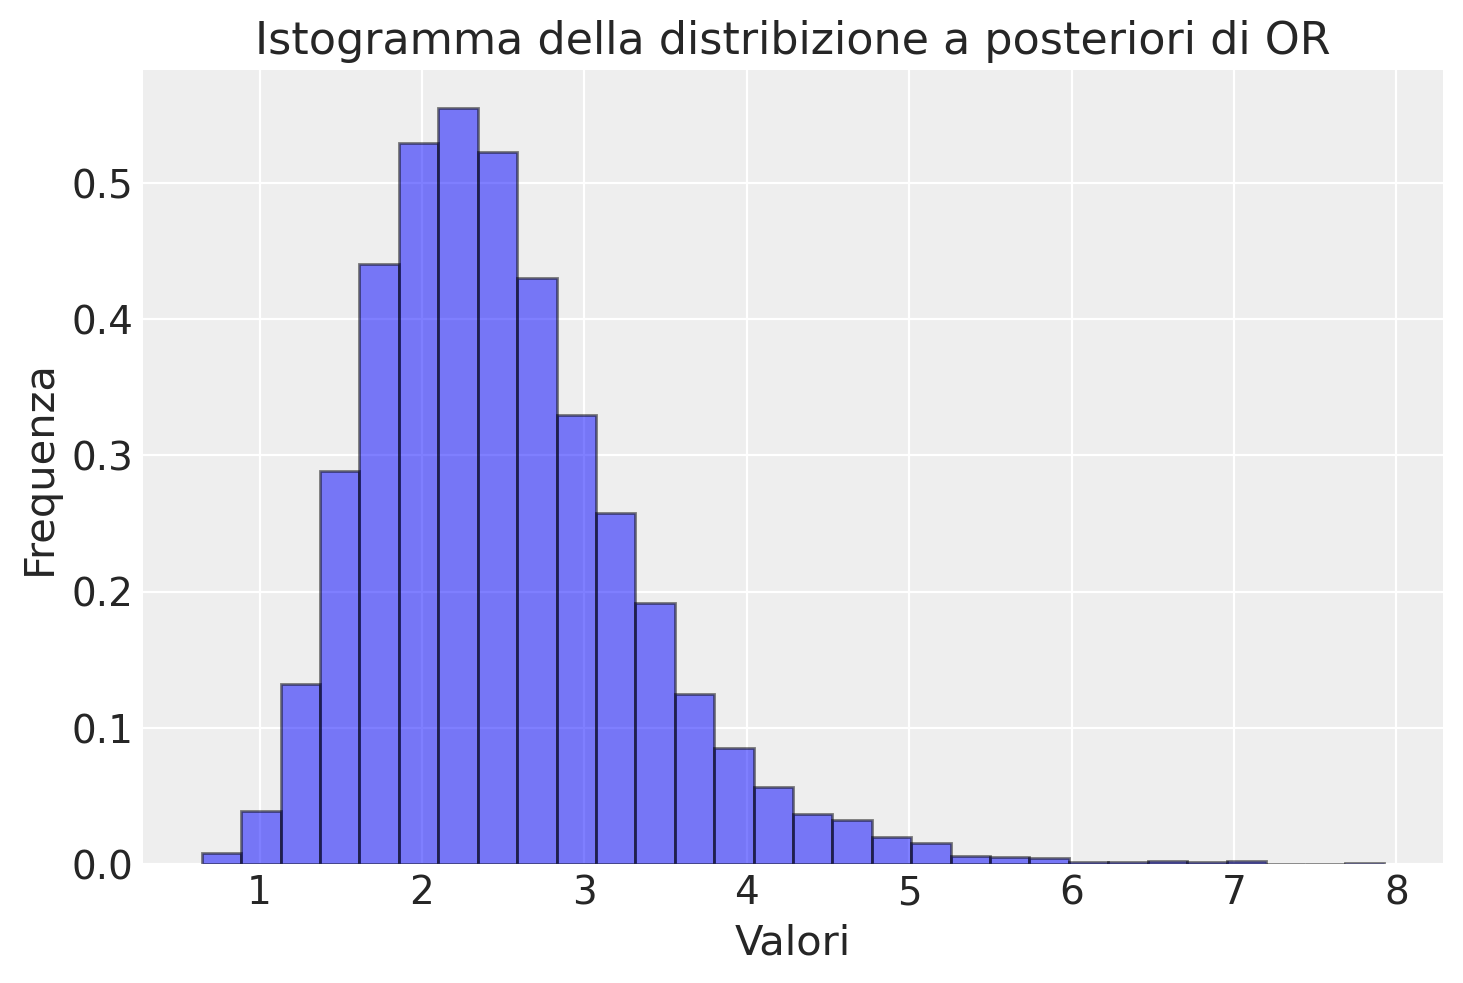

In [8]:
plt.hist(or_draws, bins=30, alpha=0.5, color='b', edgecolor='black', density=True)

# Aggiunta di titolo e etichette agli assi
plt.title('Istogramma della distribizione a posteriori di OR')
plt.xlabel('Valori')
plt.ylabel('Frequenza')

plt.show()

In [9]:
az.summary(trace, var_names=['oddsratio'], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
oddsratio,2.49,0.82,1.15,4.01,0.01,0.01,7267.0,5312.76,1.0


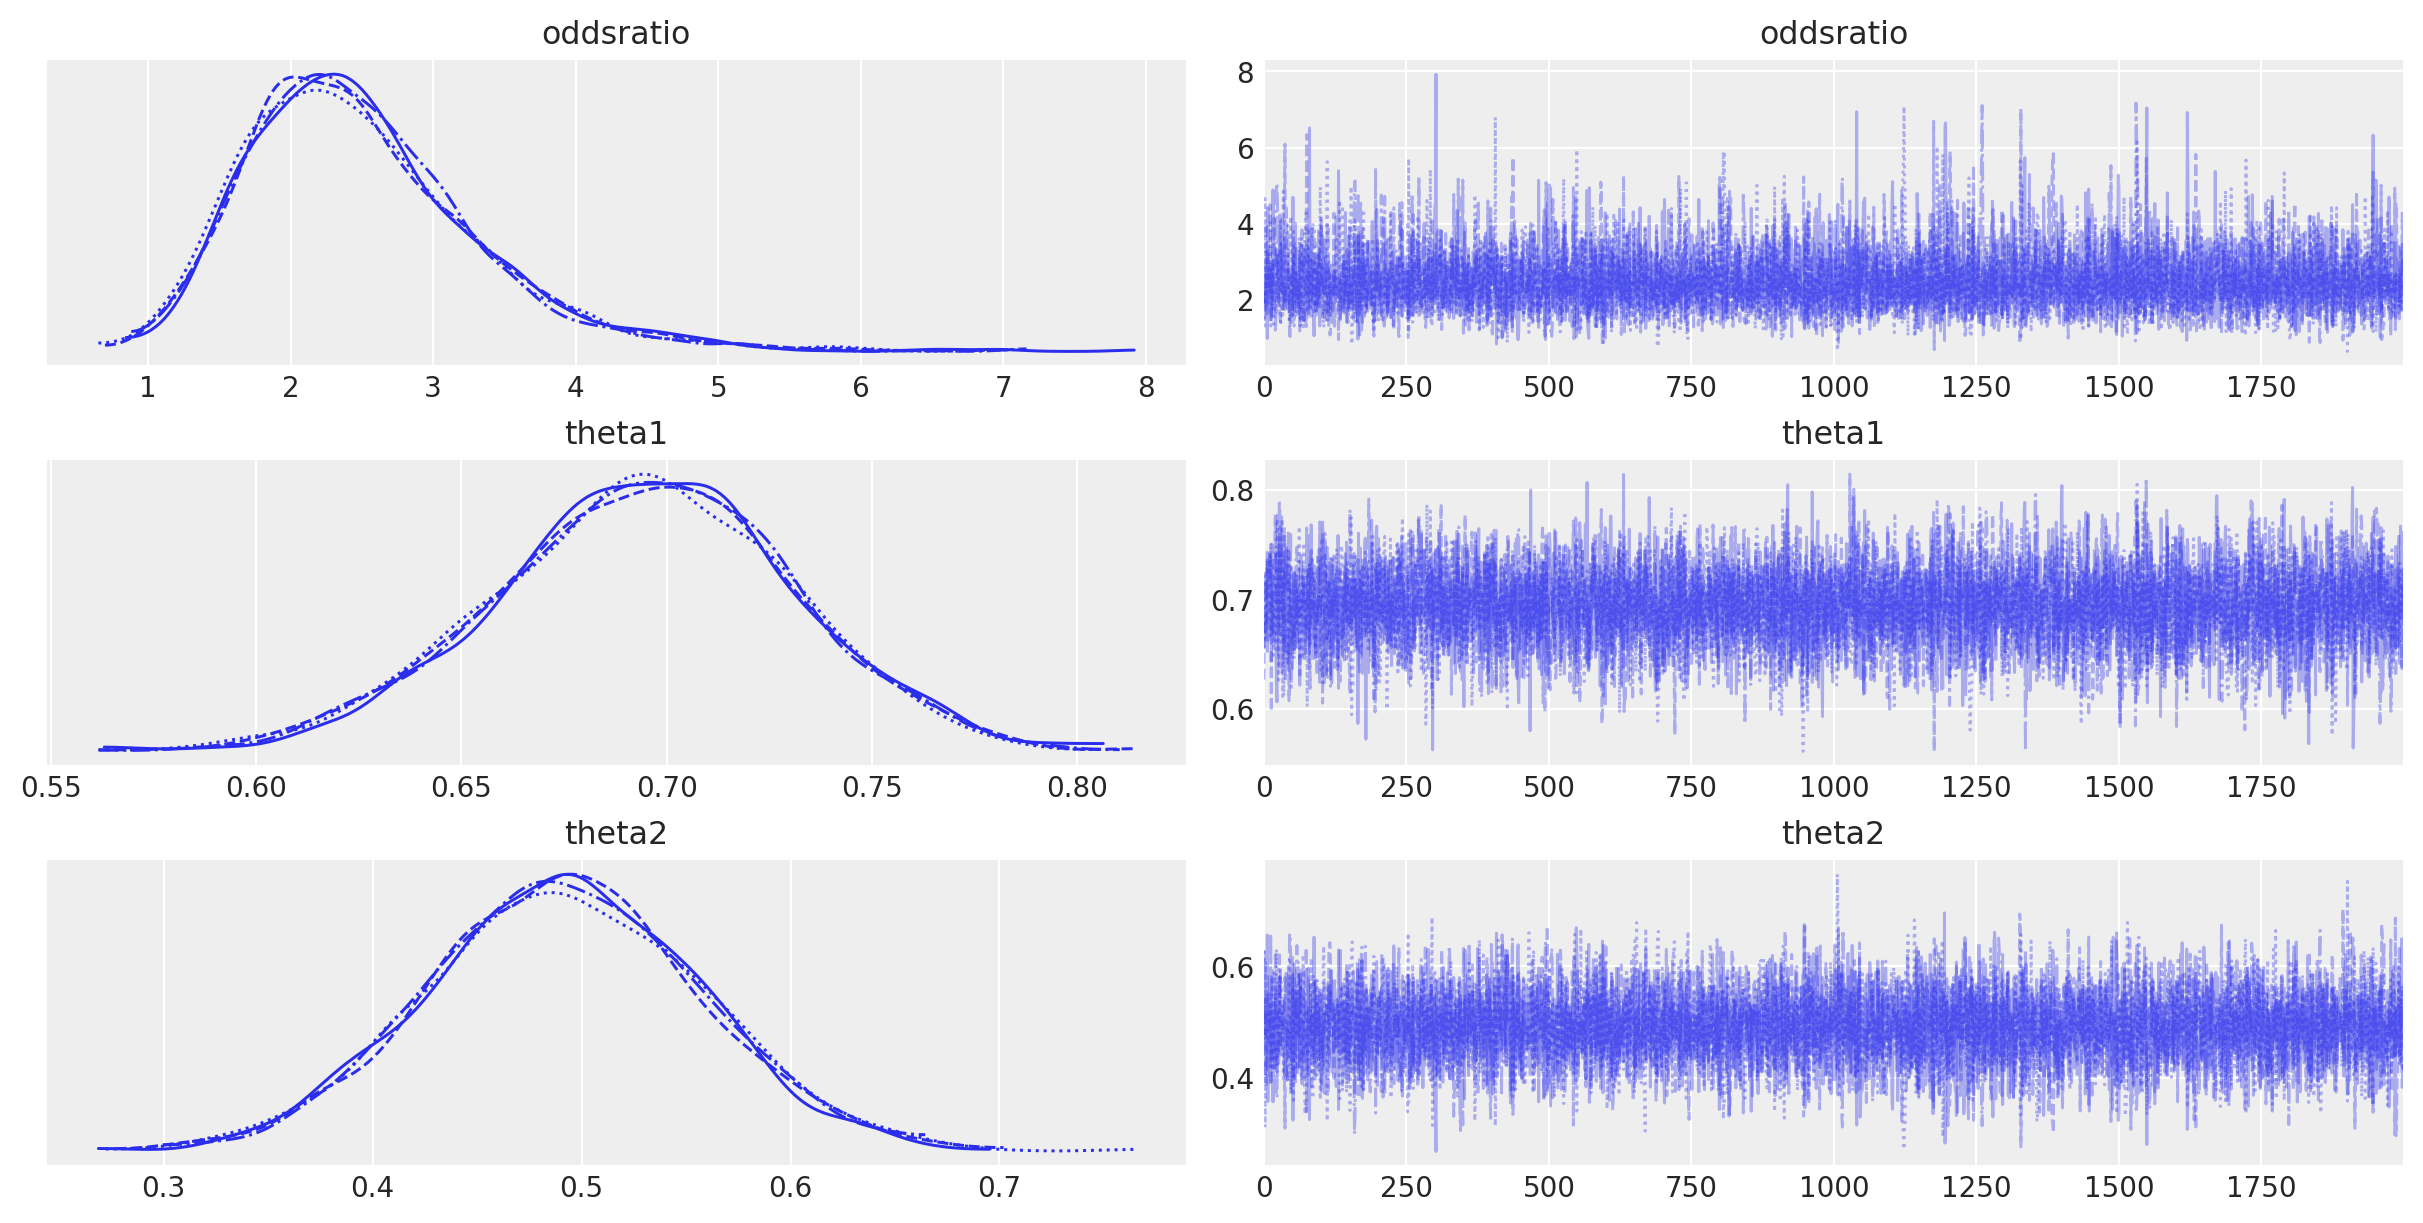

In [10]:
_ = az.plot_trace(trace)

In [11]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
oddsratio,2.490,0.816,1.148,4.014,0.010,0.007,7267.0,5313.0,1.0
theta1,0.694,0.036,0.629,0.767,0.000,0.000,6919.0,4632.0,1.0
theta2,0.491,0.065,0.367,0.612,0.001,0.001,7467.0,5423.0,1.0


In [12]:
az.rhat(trace)

<xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    oddsratio  float64 8B 1.001
    theta1     float64 8B 1.0
    theta2     float64 8B 1.001

In [13]:
az.mcse(trace)

<xarray.Dataset> Size: 24B
Dimensions:    ()
Data variables:
    oddsratio  float64 8B 0.009871
    theta1     float64 8B 0.0004364
    theta2     float64 8B 0.0007554

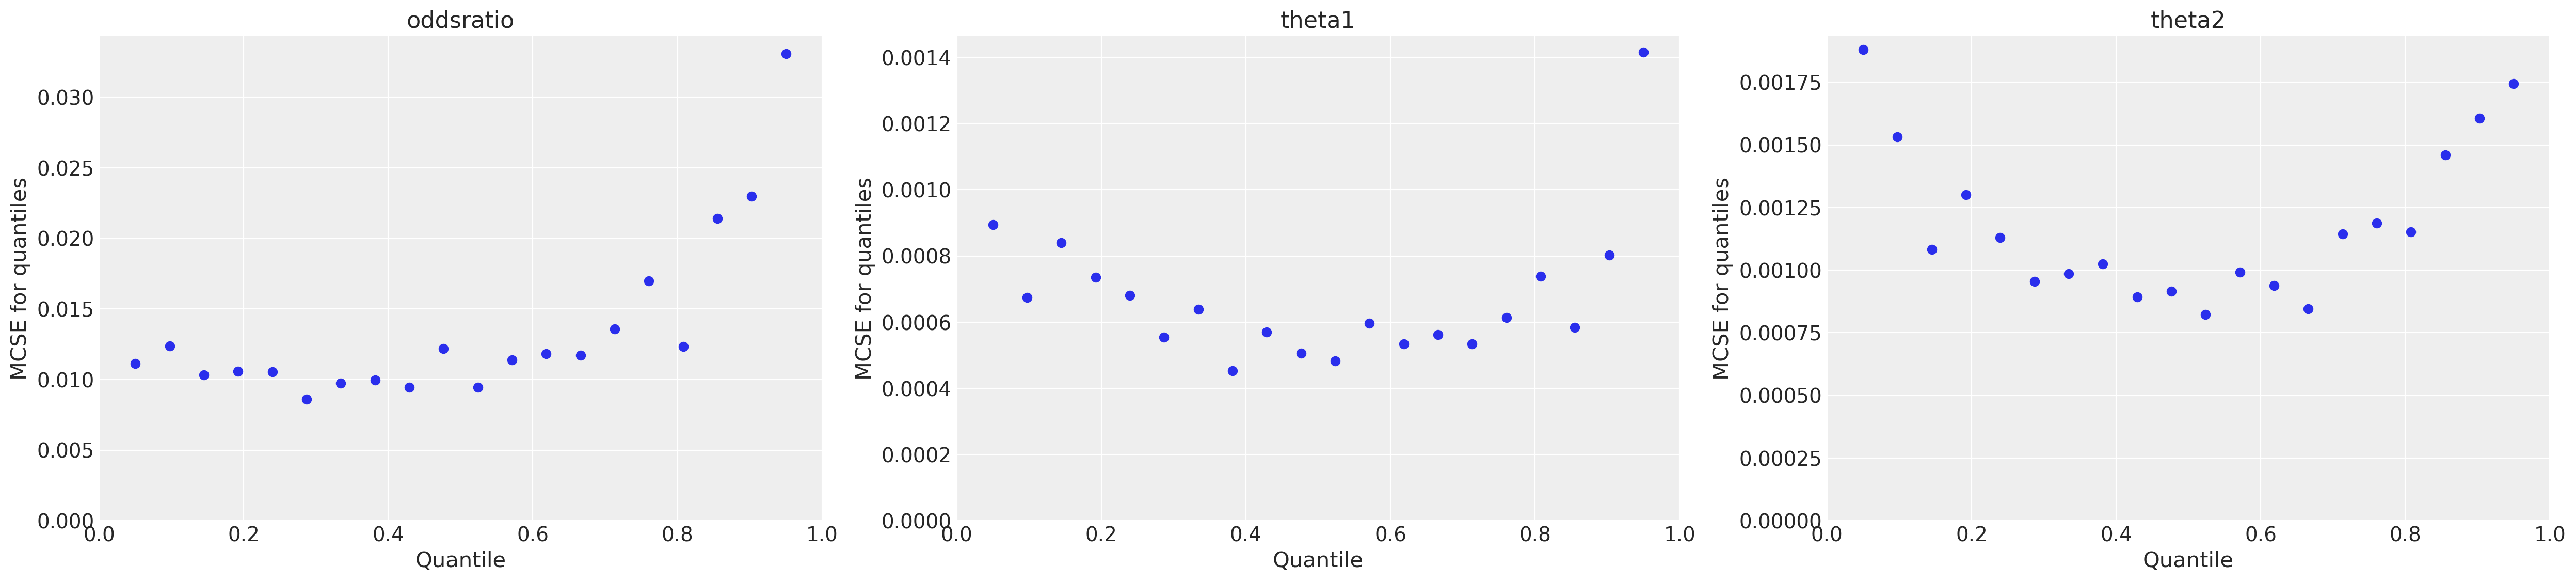

In [14]:
_ = az.plot_mcse(trace)

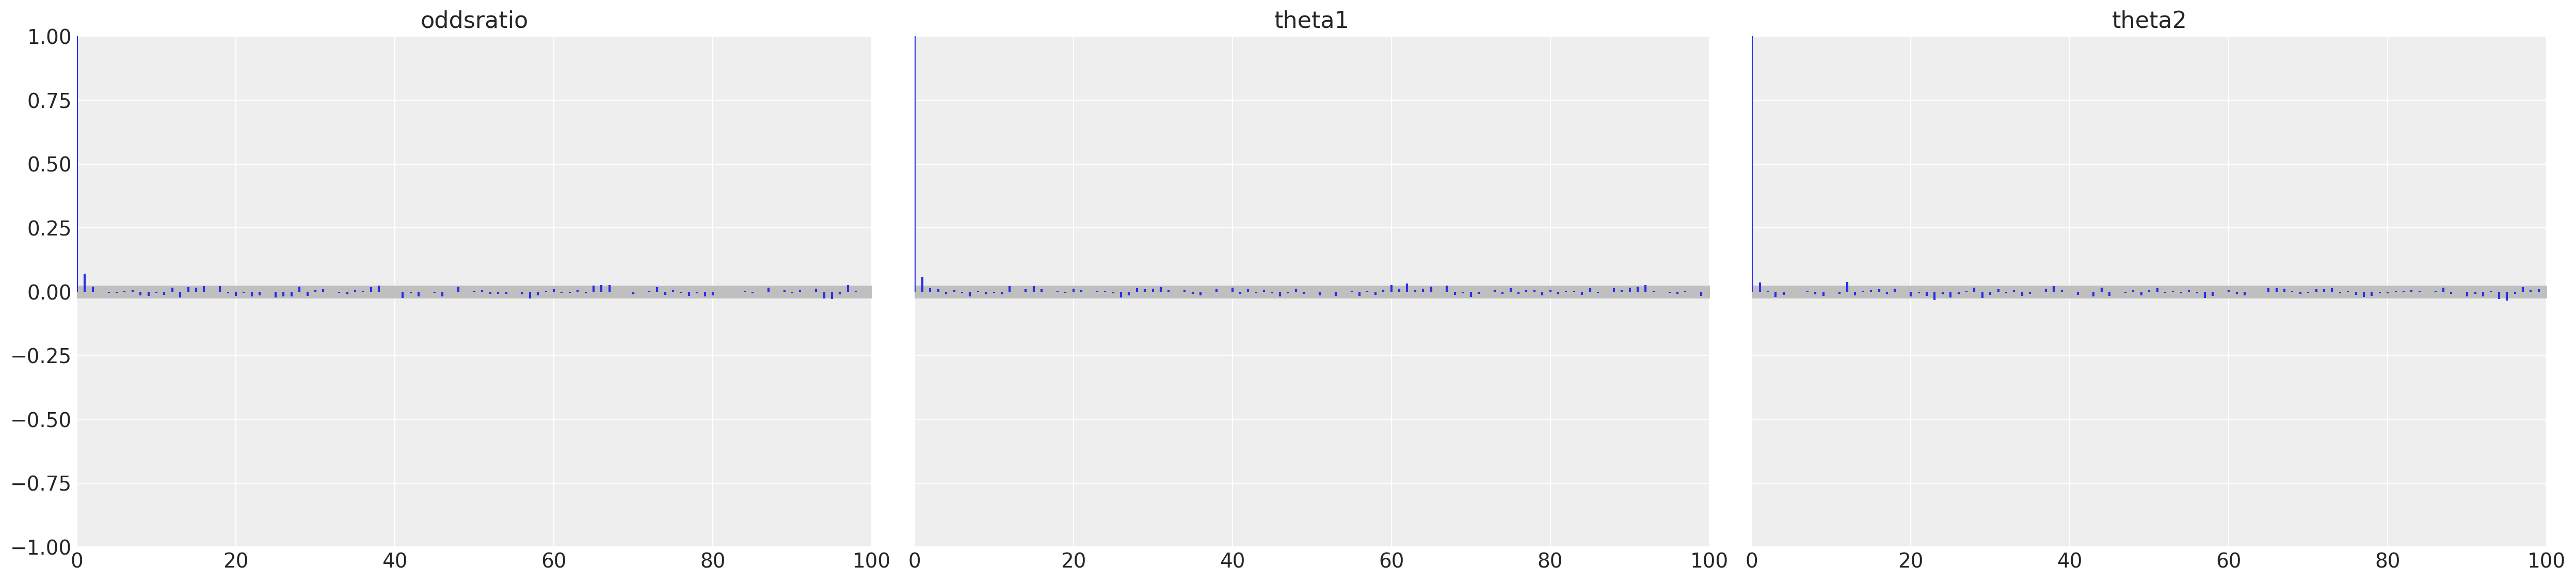

In [15]:
_ = az.plot_autocorr(trace, combined=True)

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_6960/2881571045.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()  # Adjust layout to prevent clipping


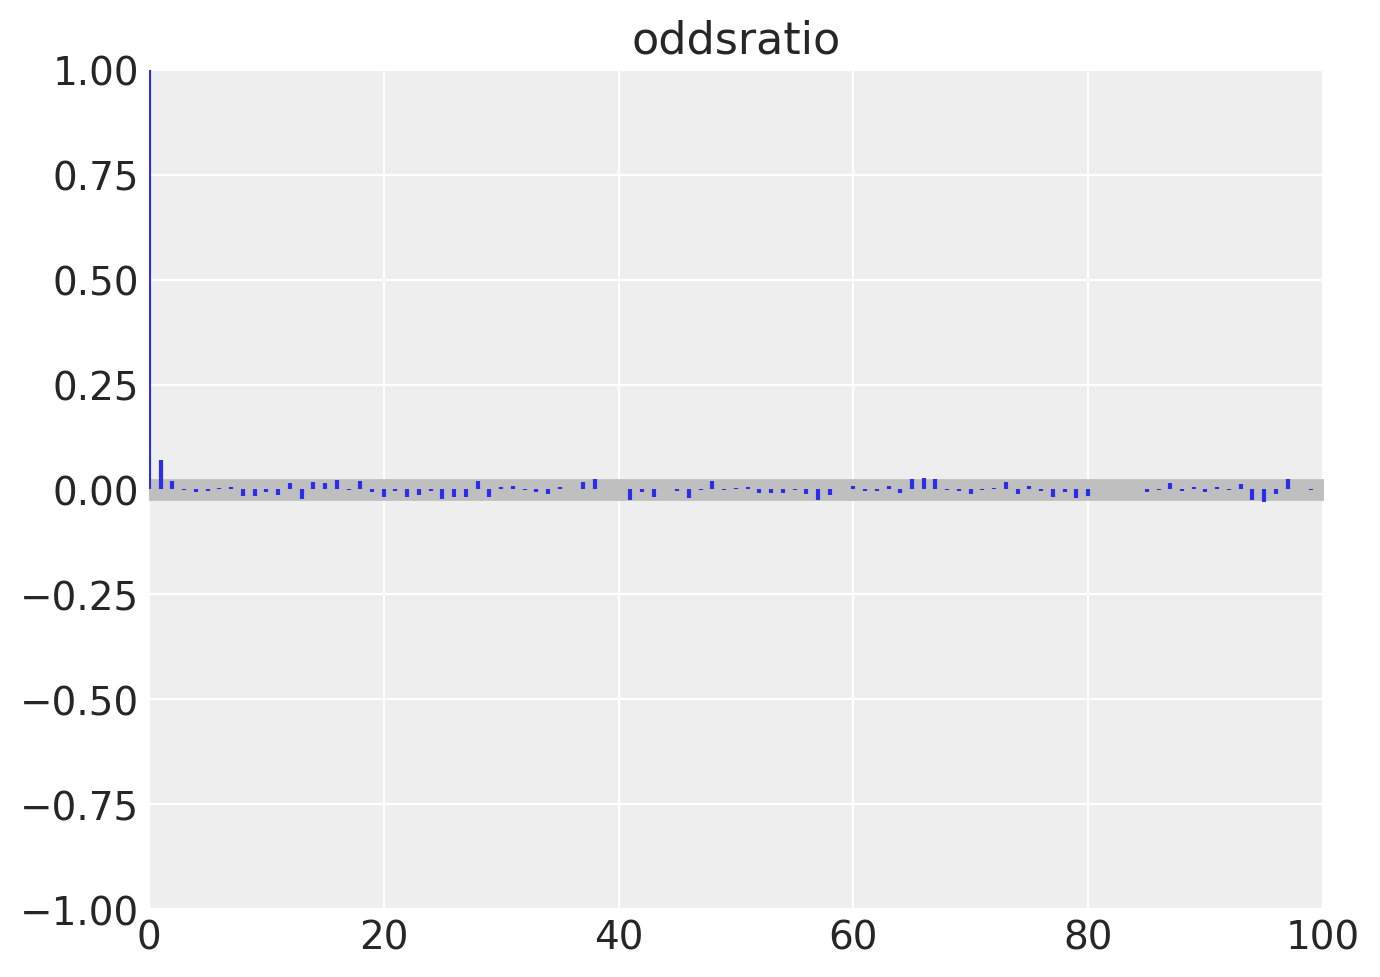

In [16]:
# Set the figure size explicitly
fig, ax = plt.subplots(figsize=(7, 5))
_ = az.plot_autocorr(trace, combined=True, ax=ax)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

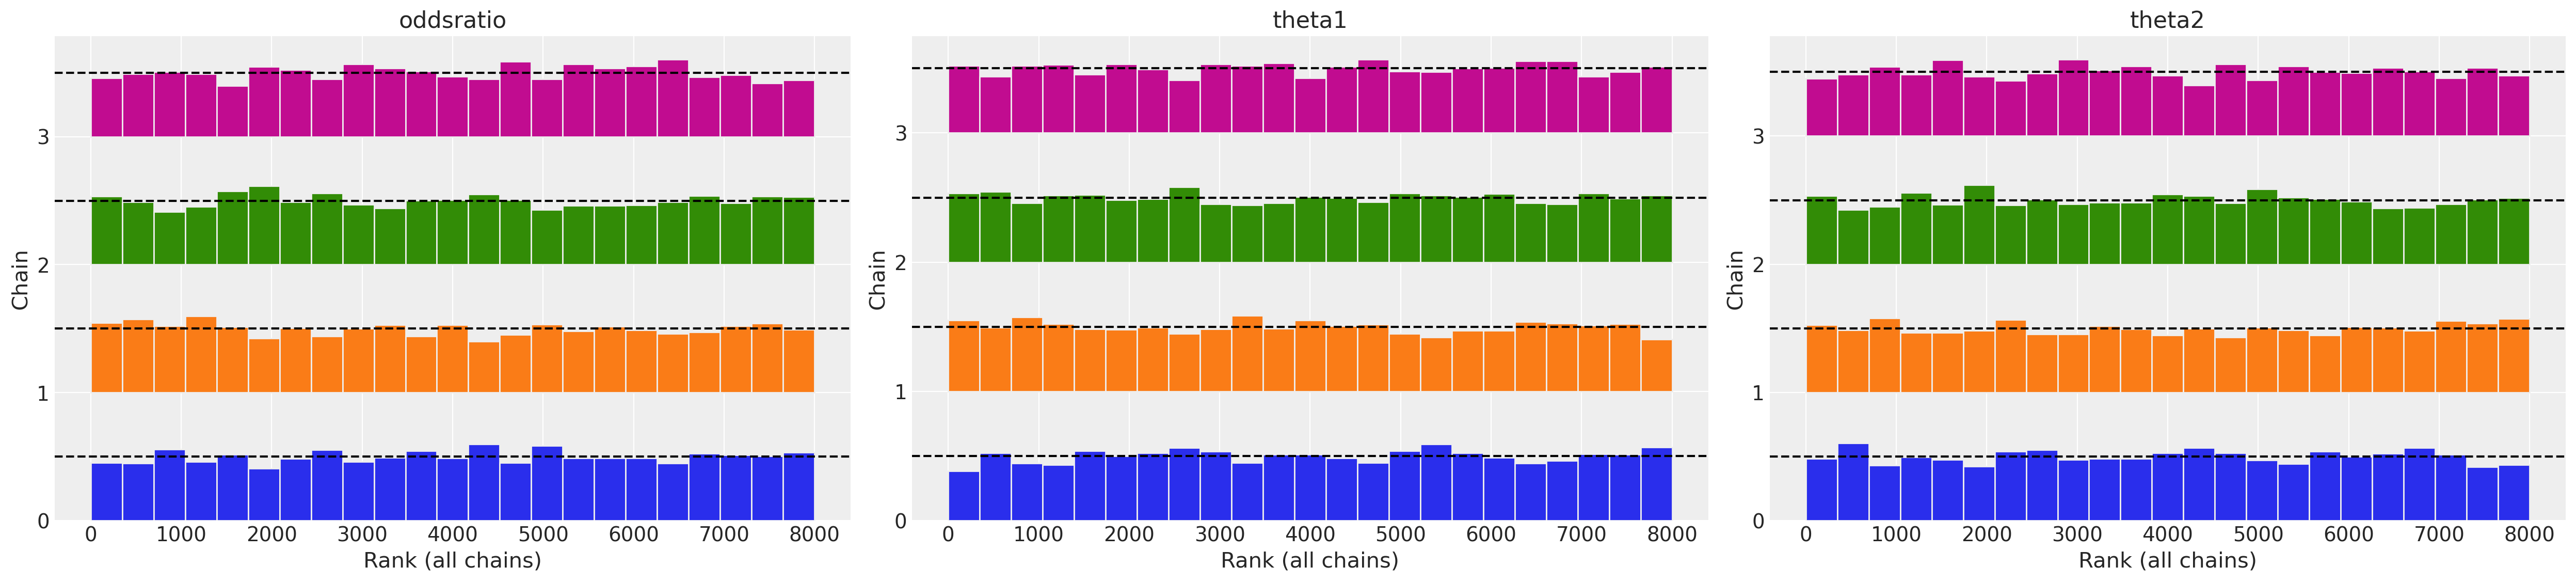

In [17]:
_ = az.plot_rank(trace, kind="bars")

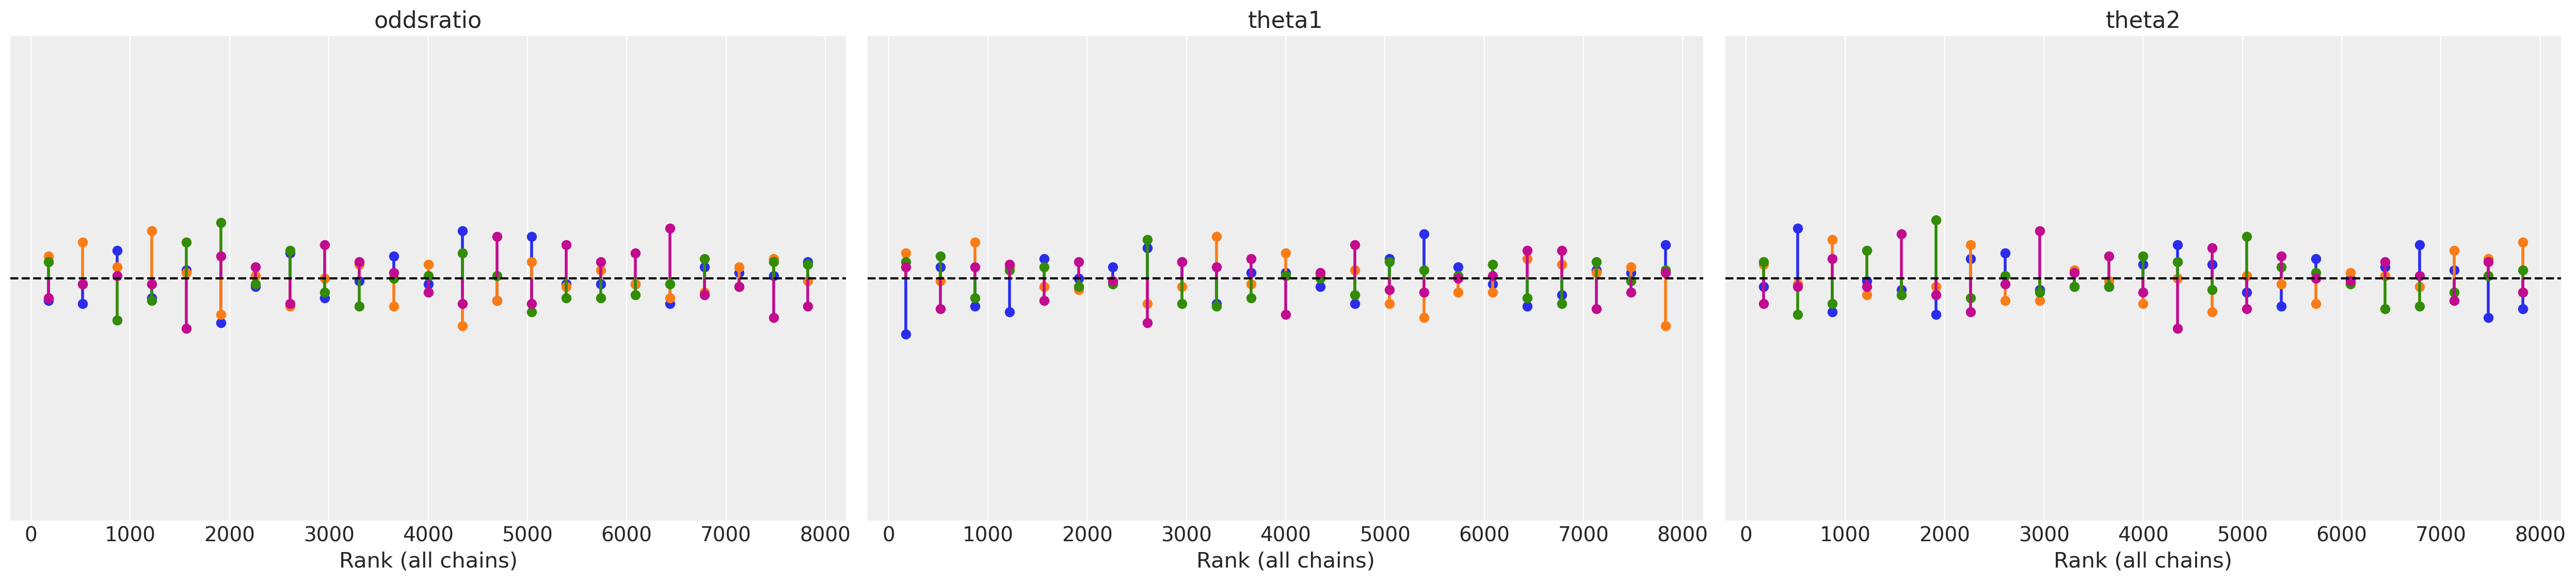

In [18]:
_ = az.plot_rank(trace, kind="vlines")

In [19]:
az.bfmi(trace)

array([1.0965385 , 1.05225675, 1.10259116, 1.09310822])

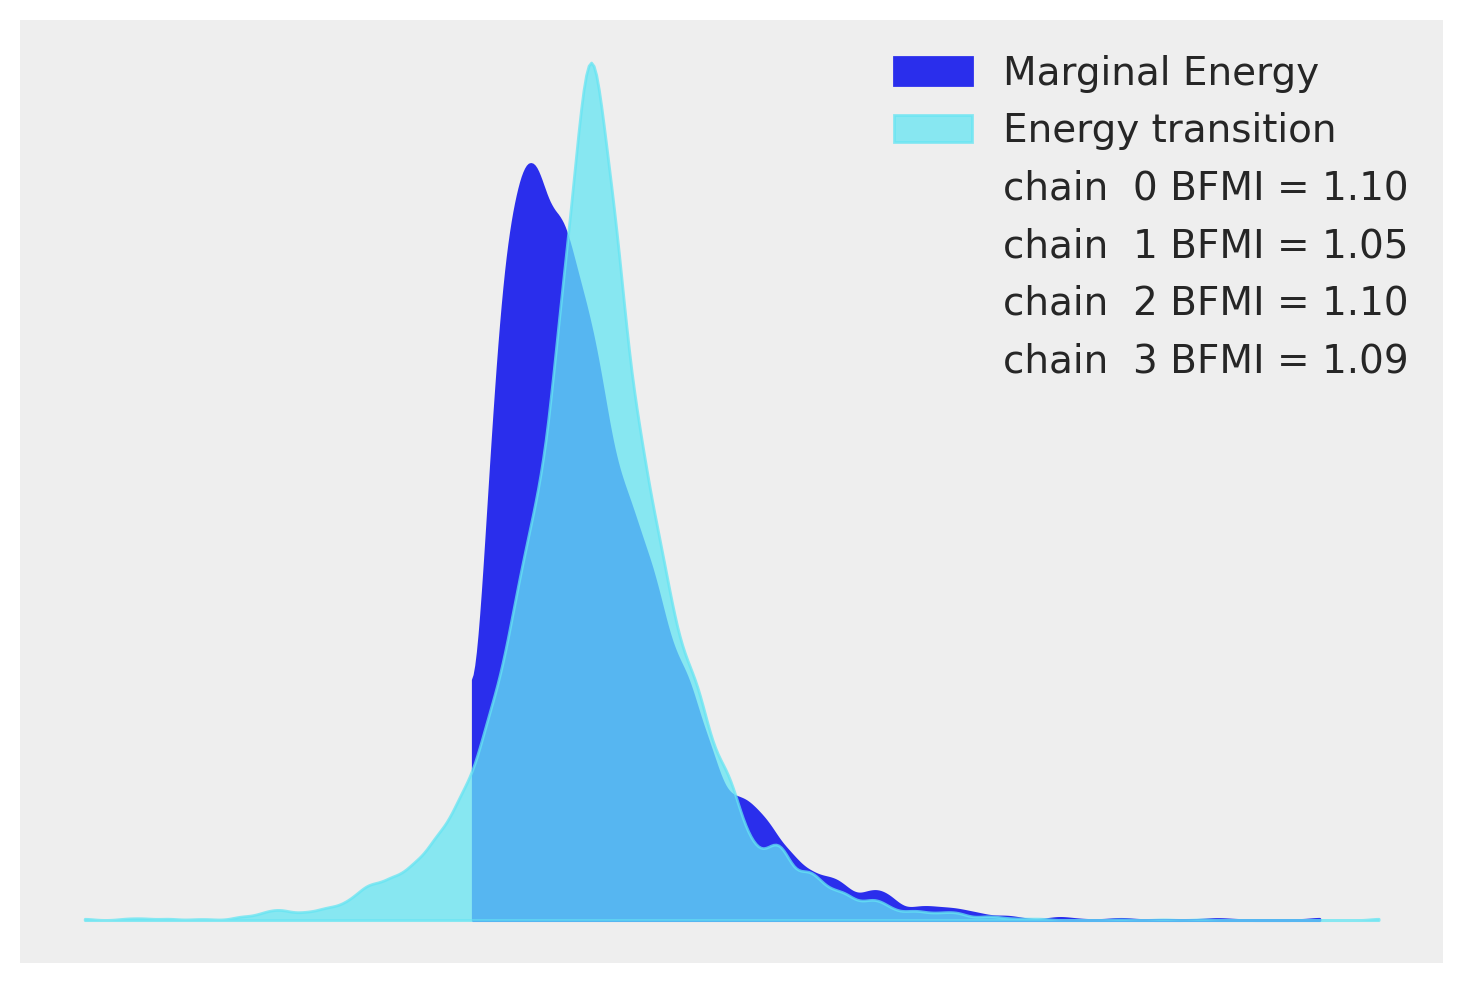

In [20]:
_ = az.plot_energy(trace)

In [21]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Sun Jun 16 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.5.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

numpy     : 1.26.4
matplotlib: 3.8.4
cmdstanpy : 1.2.3
logging   : 0.5.1.2
arviz     : 0.18.0

Watermark: 2.4.3

